# Redukcija dimenzionalnosti

Kada imamo puno nezavisnih promenljivih $x_1, x_2, ... x_n$ (atributa), često želimo da smanjimo broj atributa.
Želimo da zadržimo bitne atribute i da izbacimo one atribute koji malo (ili ni malo) ne doprinose novim informacijama. 
Postupak koji izdvaja informativne atribute zove se redukcija dimenzionalnosti. Primena: da ubrzamo treniranje modela (npr. model linearne regresije), da uklonimo neiformativne atribute i da vizualizujemo višedimenzione podatke.

### Skup podataka
Koji faktori najviše utiču na na srećan život? Od ponuđenih odgovora izaberi 3 koja najviše utiču (pozitivno ili negativno):
<form>
    <input type="checkbox"> 1. Zdravlje - koliko osoba brine o svom zdravlju.
    <br><input type="checkbox"> 2. Usamljenost - koliko se osoba oseća usamljeno.
    <br><input type="checkbox"> 3. Duhovitost - koliko je osoba duhovita.
    <br><input type="checkbox"> 4. Dobročinstvo - koliko je osoba uključena u donacije u dobrotvorne srvhe.
    <br><input type="checkbox"> 5. Agresivnost - koliko osoba ispoljava bes i ljutnju.
    <br><input type="checkbox"> 6. Energičnost - Koliko osoba ima energije.
    <br><input type="checkbox"> 7. Broj prijatelja - koliko osoba ima prijatelja.
</form>

Probaćemo da odgovorimo na ovo pitanje u nastavku koristeći podatke (više o podacima na [linku](https://www.kaggle.com/datasets/miroslavsabo/young-people-survey/data)). 
Podaci su prikupljeni u istraživanju 2013 godine, gde su ispitanici (15 do 30 godina) odgovarali na 150 pitanja koja se tiču muzike, filomova, zdravlja, vere, ličnosti, pogleda na život, navika,... Svaki atribut (kolona) je odgovor na jedno pitanje. Svako pitanje predstavljeno je kolonom u fajlu [responses.csv](data/responses.csv). Objašnjenje svake kolone nalazi se u [columns.csv](data/columns.csv) fajlu. Svaki red je jedna osoba (njeni odgovori na pitanja).

Fokusiramo se na 57 pitanja o stavovima, uverenjima i navika (ne gledamo odgovore za muziku, filmove itd). Na osnovu atributa analiziramo šta najviše utiče za srećan zivot (kolona `Happiness in life`).
**Cilj: regresioni model koji predviđa nivo sreće (kolona `Happiness in life`) na osnovu ostalih atributa.**

Za početak, učitavamo neophodne pakete, funkcije i skup podataka:

In [1]:
# ne moraš da razumeš kod iz ove ćelije
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (6, 3)
sb.set(font_scale=1.)

np.random.seed(42)

def get_fitted_model(x, y):
    '''Fits the model usting `statsmodels` package.'''
    x_with_const = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, x_with_const).fit()
    return model

def plot_correlation_for_col(df, col_name):
    plt.figure(figsize=(12,6)) # podesimo velicinu grafika
    correlation_matrix = df.corr() # racunamo matricu korelacije
    sorted_col_corr = correlation_matrix[col_name].sort_values(ascending=True) # indeksiramo kolonu i soritramo vrednosti
    sorted_col_corr = sorted_col_corr.drop(col_name) # izbacujemo vrednost samu sa sobom
    sb.barplot(x=sorted_col_corr.index, y=sorted_col_corr.values, palette='RdBu')
    plt.xticks(rotation=90);
    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca_model):
    '''Plots the explained variance plot using a trained PCA model.'''
    plt.figure(figsize=(9,3)) # podesimo velicinu grafika
    
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center')
    plt.xlabel('Glavna komponenta')
    plt.ylabel('Objasnjena varijansa')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, '--o')
    plt.xlabel('Broj glavnih komponenti')
    plt.ylabel('Kumulativna varijansa')

    plt.tight_layout()
    plt.show()

def plot_pc_loading(pca_model, pc_idx, columns, largest_n_pc=None):
    plt.figure(figsize=(12,6)) # podesimo velicinu grafika

    pc_loadings_df = pd.DataFrame(data=pca_model.components_, columns=columns)
    loading = pc_loadings_df.iloc[pc_idx]
    sorted_loading_abs = loading.abs().sort_values(ascending=True)

    largest_n_pc = 0 if largest_n_pc is None else largest_n_pc
    sorted_loading = loading[sorted_loading_abs.index][-largest_n_pc:]
    sb.barplot(x=sorted_loading.index, y=sorted_loading.values, palette='Reds')
    plt.xticks(rotation=90);
    plt.title(f'Korelacija atributa sa {pc_idx}. komponentom')
    plt.tight_layout()
    plt.show()


def visualize_principal_components(principal_components:np.ndarray, n_principal_components:int, target_col=None):
    '''
    Visualizes principal components in 2D or 3D.

    Parameters:
    - principal_components (np.ndarray): The principal components to visualize.
    - n_principal_components (int): Number of principal components (2 or 3).
    - target_col (pd.Series): Target column for color differentiation in the plot.
    '''
    if n_principal_components == 2:
        fig = px.scatter(x=principal_components[:, 0], y=principal_components[:, 1],
                    opacity=0.6, color=target_col, color_continuous_scale='RdBu', width=700, height=600)
        fig.update_traces(marker={'size':10})
        fig.update_layout(title='Vizualizacija glavnih komponenti', xaxis_title="PC1", yaxis_title="PC2")

        fig.show()

    elif n_principal_components == 3:
        fig = px.scatter_3d(x=principal_components[:, 0], y=principal_components[:, 1], z=principal_components[:, 2],
            opacity=0.6, color=target_col, color_continuous_scale='RdBu', width=1000)
        fig.update_traces(marker={'size':6})
        fig.update_layout(title='Vizualizacija glavnih komponenti', scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3",
                                     xaxis_autorange='reversed', yaxis_autorange='reversed')) 
        fig.show()
    
    else: raise Exception('number of principal components must 2  or 3')

In [2]:
df = pd.read_csv('data/responses.csv', sep=',')
print(f'Ukupan broj redova: {df.shape[0]} i atributa: {df.shape[1]}')
df.head()

Ukupan broj redova: 1010 i atributa: 150


,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


### Pretprocesiranje
Ne koristimo svih 150 atributa, već se fokusiramo na odgovore o stavovima, uverenjima i navikama. Izdvajamo te kolone i uklanjamo nedostajuće vrednosti. Zatim proveravamo da li sve kolone imaju numeričke vrednosti (neke kolone nemaju numeričke vrednosti). Odgovori su uglavnom u rasponu od 1 (ne slažem se uopšte) do 5 (slažem se u potpunosti), ali neki odgovori su stringovi, a ne brojevi od 1 do 5.

In [3]:
df = df.iloc[:, 76:76+57] # izdvajamo kolone koje sadrže odgovore uverenjima/navikama
df = df.dropna() # uklanjamo redove sa nedostajućim vrednostima

# zelimo da predvidimo nivo sreće pojedinca
y = df['Happiness in life']

# dobijamo grešku ako treniramo model jer određene kolone sadrže stringove
# x, y = df.drop(columns=['Happiness in life']), df['Happiness in life']
# model = get_fitted_model(x, y)

# proveravamo koje kolone ne sadrže brojeve
cols = df.select_dtypes(exclude=['int', 'float']).columns
print(cols)

Index(['Punctuality', 'Lying', 'Internet usage'], dtype='object')


### Kategoričke vrednosti
Neka pitanja nemaju numeričke vrednosti, već kategoričke vrednosti. Kategoričke vrednosti treba pretvoriti u numeričke (brojeve), kako bismo mogli da treniramo model. Ovakvu transformaciju podataka zovemo enkodovanje.
U našem primeru, kategorički atributi i njihove vrednosti su:
- Punctuality - 'I am always on time', 'I am often early', 'I am often running late'
- Lying - 'never', 'sometimes', 'every time it suits me', 'only to avoid hurting someone'
- Internet usage - 'few hours a day', 'less than an hour a day', 'most of the day', 'no time at all'

***Ordinal encoding*** - Svaku kategoriju enkodira u numeričku vrednost na osnovu poretka. Koristimo kada postoji redosled u kategorijama.
Koristimo metodu `map()` da enkodiramo kolone *Punctuality* i *Internet usage*, jer postoji redosled u tim kategorijama.

***One-hot encoding*** - Svaku kategoriju enkodira one-hot vektorom. One-hot vektor sadrži sve nule i jedinicu na poziciji koja predstavlja kategoriju (npr. [0, 0, 1, 0]). Koristimo kada ne postoji jasan redosled u kategorijama.
Koristimo metodu `pd.get_dummies()` da enkodiramo kolonu *Lying* u kojoj ne postoji jasan redosled u kategorijama. Kolonu *Lying* zamenićemo sa 4 nove kolone (jer imamo 4 moguće kategorije). Na primer, vrednost 'most of the day' zamenićemo vektorom [0, 0, 1, 0] (jedinica se nalazi u koloni za odgovarajuću kategoriju, a nula u ostalim kolonama).

*Napomena: u `pd.get_dummies(... drop_first=True)` stavljamo parametar `drop_first=True` kako bismo izbacili prvi kategorički atribut i izbegli savršenu kolinearnost u podacima.*

In [4]:
df['Punctuality'] = df['Punctuality'].map({'i am often running late': 0, 'i am always on time': 1, 'i am often early': 2})
df['Internet usage'] = df['Internet usage'].map({'no time at all': 0, 'less than an hour a day': 1, 'few hours a day': 2, 'most of the day': 3})

df = pd.get_dummies(df, columns=['Lying'], drop_first=True).astype(int)

x, y = df.drop(columns=['Happiness in life']), df['Happiness in life']
model = get_fitted_model(x, y)
print(f'adj r^2={model.rsquared_adj:.5f}')

adj r^2=0.39603


Trenutni model koristi 58 atributa (kolona) kako bi procenio nivo sreće.
Pogledajmo koliko svaki atribut pojedinačno utiče na ciljnu kolonu *Happiness in life*.
Posmatramo korelaciju sa kolonom za sreću. Umesto velike matrice korelacije, posmatramo samo jedan red matrice korelacije - *Happiness in life*.

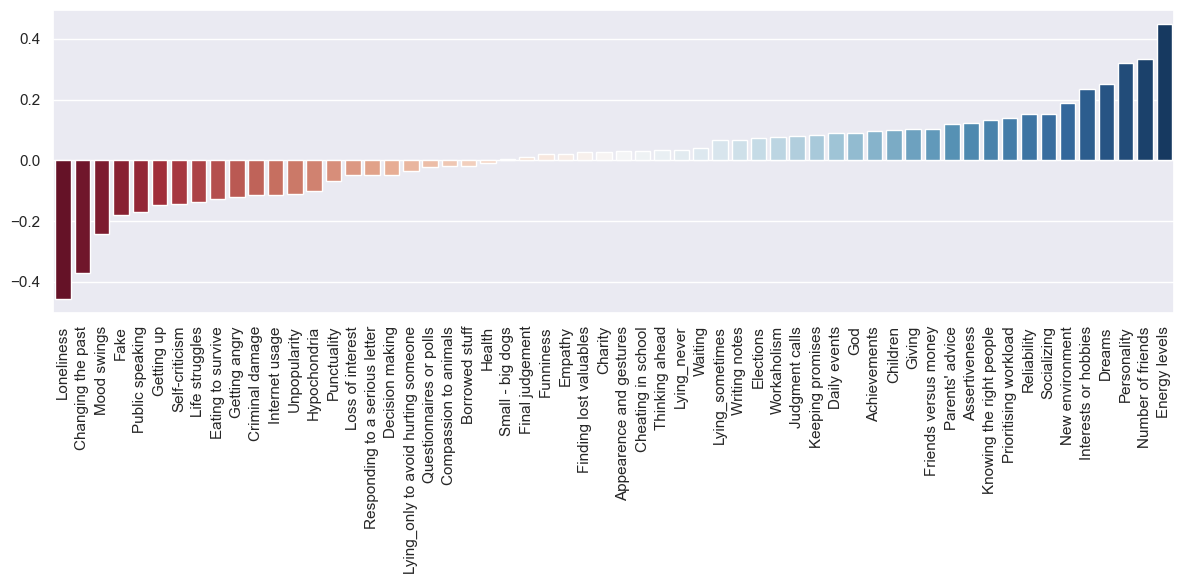

In [5]:
plot_correlation_for_col(df, col_name='Happiness in life')

Vidimo da je najveća negativna korelacija sa atributom `Loneliness` (usamljenost) i najveća pozitivna korelacija sa atributom `Energy levels` (nivo energije). Ove dve kolone pojedinačno najviše utiču na nivo sreće. Očekujemo da će glavne komponente zavisiti dosta od ovih atributa, što ćemo i pokazati u nastavku.

<img style="float:right; max-width:400px" src="imgs/pca.png" width="60%" />

## PCA
Postoji više algoritama za redukciju dimenzionalnosti, a mi koristimo analizu glavnih komponenti - PCA (eng. *Principal Component Analysis*).
PCA od originalnih atributa formira nove atribute (zovemo **komponente**). Svaka komponenta je linearna kombinacija originalnih atributa.
PCA pronalazi komponente koje sadrže najviše informacija. Formira komponente tako da najveći značaj imaju informativni atributi, a mali značaj neinformativni atributi. Kako PCA zna koji atributi su informativni? To su atributi koji imaju najveću varijabilnost (široko rasuti podaci). 
Alternativna formulacija: PCA pronalazi novi koordinatni sistem koji minimizuje ukupnu grešku rekonstrukcije.

### Pretprocesiranje
Veoma bitan korak pre primene PCA algoritma je pretprocesiranje. Podaci moraju biti centrirani, a poželjno ih je i skalirati da budu u sličnom opsegu (velike razlike u opsezima su problem za PCA algoritam).
U nastavku je dat kod za standardizaciju koji centrirana i skalira podatke. Koristimo klasu `StandardScaler()`.

*Napomena: Postoje različiti mehanizmi za skaliranje podataka (Normalizer, MaxAbsScaler, MinMaxScaler,...). Koji je najbolji, zavisi od problema i samih podataka. Različiti mehanizmi daju različite rezultate.*

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=x.columns)
df['Happiness in life'] = y.values
df.head()

,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,...,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Lying_never,Lying_only to avoid hurting someone,Lying_sometimes,Happiness in life
0,-0.942941,-0.518185,1.354395,0.781611,-1.272082,1.744606,0.150479,-0.001309,-1.229884,-0.715353,...,0.119092,-1.237266,-0.457295,0.850795,0.209656,0.045307,4.316985,-0.609449,-1.102445,4
1,-0.060275,-0.518185,0.649457,1.564127,0.494926,-1.175180,0.150479,-0.001309,0.259422,0.189574,...,0.922960,1.064954,-0.457295,-1.482815,0.209656,0.045307,-0.231643,-0.609449,0.907075,4
2,-1.825608,-0.518185,1.354395,-0.000906,1.378430,0.284713,0.150479,1.130062,-1.229884,1.094501,...,0.119092,0.297548,1.242072,-0.316010,-1.638744,0.045307,-0.231643,-0.609449,0.907075,4
3,-0.060275,-1.335178,-0.760419,-0.000906,1.378430,1.744606,1.216165,-0.001309,-0.485231,-0.715353,...,-0.684777,0.297548,-0.457295,-0.316010,0.209656,0.045307,-0.231643,-0.609449,-1.102445,3
4,-0.942941,-0.518185,-0.055481,-0.000906,-0.388578,-1.175180,-0.915207,-0.001309,0.259422,-1.620281,...,0.119092,-0.469859,1.242072,-0.316010,1.133857,0.045307,-0.231643,1.640825,-1.102445,3


### Primena PCA na podatke
U trenutnom modelu višestruke regresije ima puno atributa, a dobar deo njih je nepotreban. Zato redukujemo dimenzionalnost sa ciljem da u komponentama sačuvamo najbitnije atribute.

Primenjujemo PCA na podatke, i kao rezultat dobijamo komponente u `principal_components`. Umesto originalnih 57 atributa, dobijamo 50 novih atributa.
Izdvajamo prvih *K=50* komponenti i sa tim podacima tražimo parametre regresionog modela.

In [7]:
x = df.drop(columns=['Happiness in life'])
y=df['Happiness in life']

# pravimo PCA model
pca_model = PCA(n_components=50, random_state=42)
# primenjujemo PCA na originalne atribute
principal_components = pca_model.fit_transform(x)
# procenat informacija koji smo sačuvali iz originalnih podataka
print(f'ukupna varijansa: {sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

# umesto originalnih podataka koristimo glavne komponente da nađemo parametre linearnog modela
model = get_fitted_model(x=principal_components, y=y)
print(f'adj r^2={model.rsquared_adj:.5f}')

ukupna varijansa: 94.7%
adj r^2=0.39024


Ovim smo smanjili broj komponenti, a prilagođena $r^2$ mera je ostala ~ ista, a izbacili smo ~ 5% nepotrebnih informacija.

### Odabir *K*
Kako odabrati broj komponenti *K* koje zadržavamo? Ako je cilj vizualizacija podataka, onda biramo $K=2$ ili $K=3$.
Ako je cilj brži trening modela, onda gledamo koliko svaka komponenta objašnjava varijansu u podacima. Tada možemo da izaberemo *K* tako da: 
- zadržimo određeni procenat ukupne varijanse (npr. 95% kao u našem slučaju) ili, 
- koristimo 'metod lakta' i preko grafika određujemo koji je to broj komponenti koje treba zadržati.

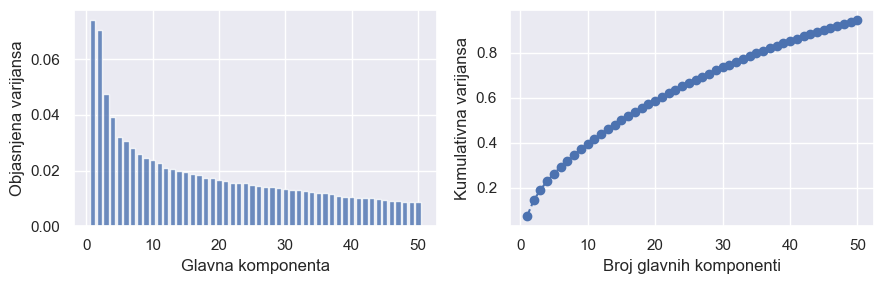

In [8]:
plot_explained_variance(pca_model)

In [9]:
# PCA sa 10 komponenti - puno informacija gubimo, ali dobijamo mnogo jednostavniji model
pca_model = PCA(n_components=10, random_state=42)
principal_components = pca_model.fit_transform(x)
print(f'ukupna varijansa: {sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

model = get_fitted_model(x=principal_components, y=y)
print(model.summary())

ukupna varijansa: 39.6%
                            OLS Regression Results                            
Dep. Variable:      Happiness in life   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     44.52
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           3.17e-71
Time:                        10:38:48   Log-Likelihood:                -882.16
No. Observations:                 864   AIC:                             1786.
Df Residuals:                     853   BIC:                             1839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6944      0

### Tumačenje glavnih komponenti
Da bismo mogli da tumačimo komponente, moramo računati korelaciju komponente i originalnih atributa. Posmatramo najjače korelacije po apsolutnoj vrednosti.

Prva glavna komponenta PC1 ima najveću korelaciju sa: nivoom energije, brojem prijatelja, hobijem, usamljenošću,...
Vidimo da PC1 odražava neaktivnost osobe (kroz nedruštvenost). PC1 raste kada raste neaktivnost, tj. PC1 opada kada se povećava društvenost.
Negativan koeficijent uz PC1 (vidi se iz `model.summary()`) označava inverznu zavisnost ➡️ nivo sreće raste kada PC1 opada, a PC1 opada kada se povećava društvenost ➡️  društvene i energične osobe imaju viši nivo sreće.

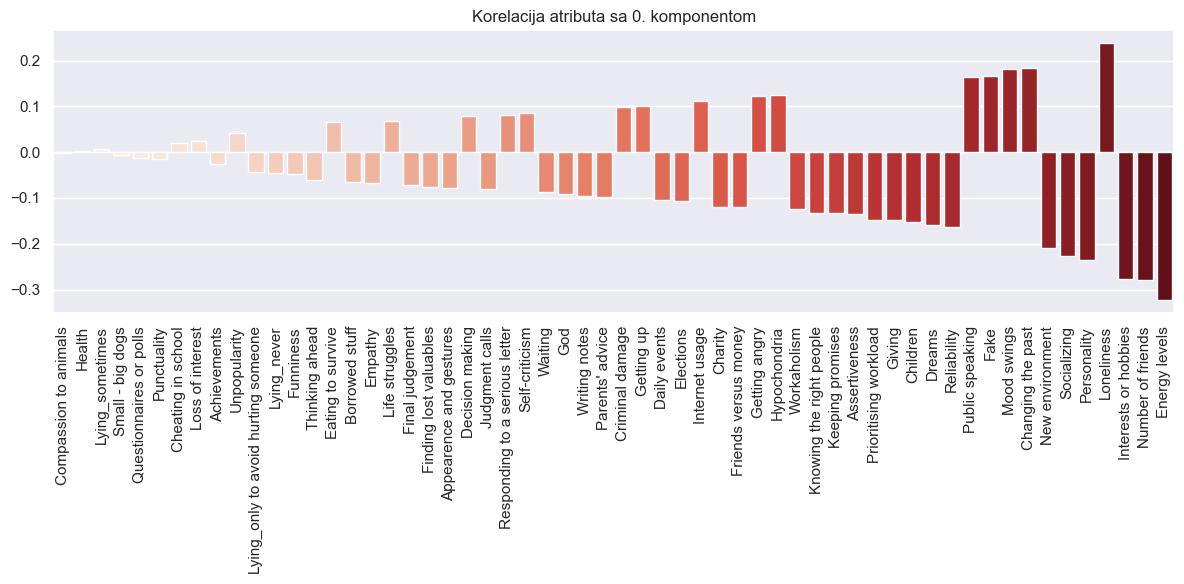

In [10]:
plot_pc_loading(pca_model, 0, x.columns)

Vidimo da se PC2 najviše asocira sa pripremljenošću, organizovanošću, marljivošću, odgovornošću,... 
PC2 raste kada se povećavaju ovi kvaliteti.
Koeficijent uz drugu glavnu komponentu je blago negativan ➡️ smanjenjem navedenih osobina blago se povećava nivo sreće.

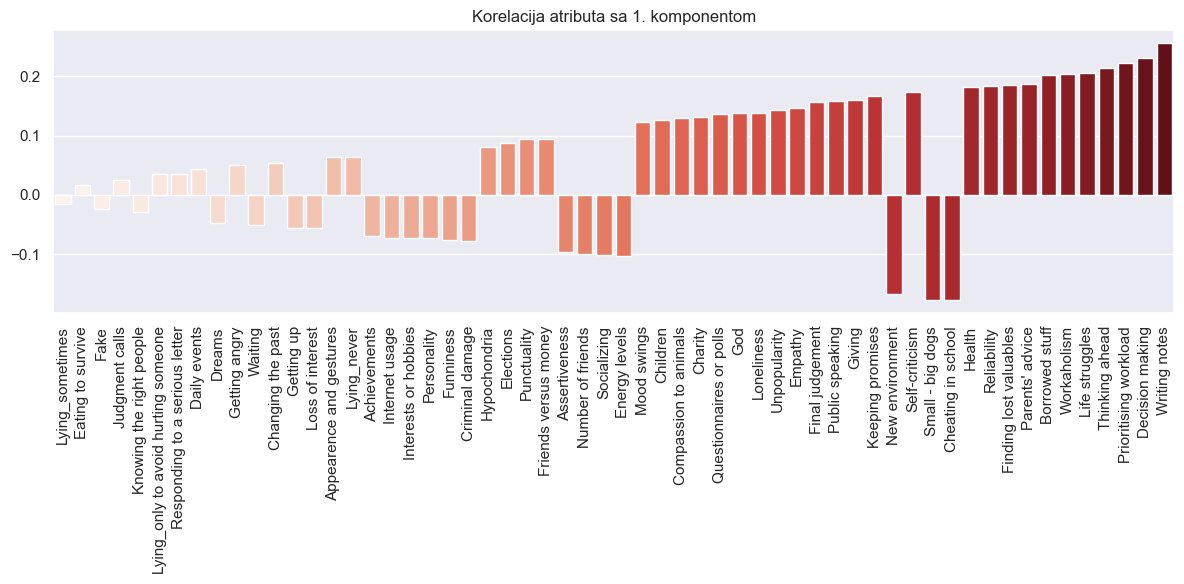

In [11]:
plot_pc_loading(pca_model, 1, x.columns)

Treća glavna komponenta PC3 se najviše asocira sa ispoljavanjem besa, agresivnosti, uništavanjem, varanjem... 
PC3 raste kako raste agresivnost.
Koeficijent uz PC3 je blago negativan ➡️ smanjenjem agresivnosti blago raste nivo sreće.

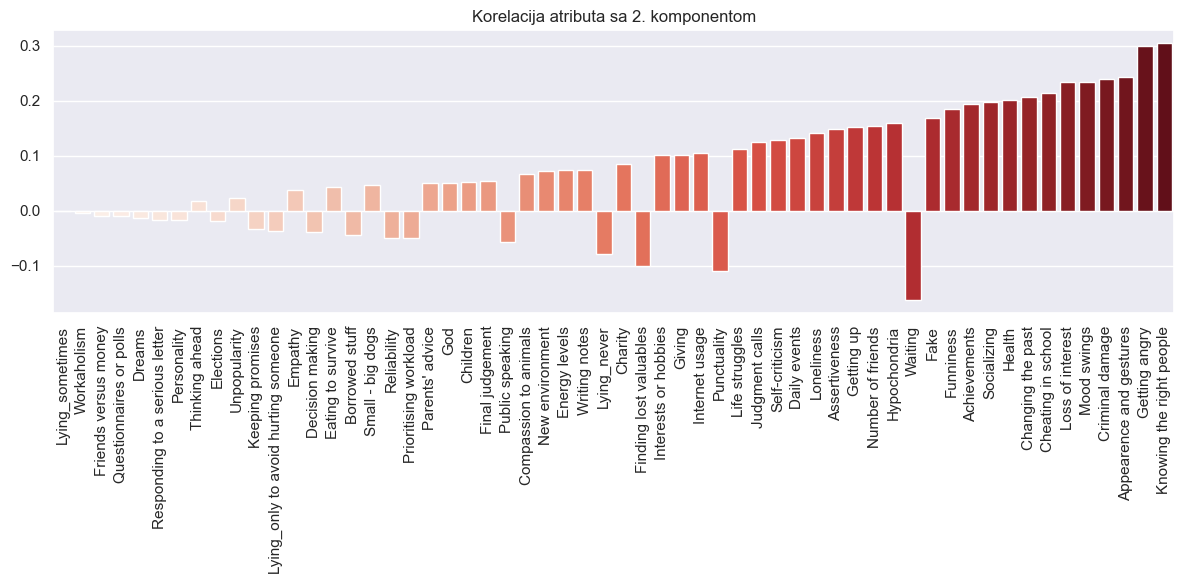

In [12]:
plot_pc_loading(pca_model, 2, x.columns)

Ukratko, primenili smo PCA i trenirali model. Rezultati PCA algoritma ukazuju da su energičnost, pripremljenost i agresivnost glavne komponente koje utiču na nivo sreće.

### Vizualizacija PCA
Možemo prikazati prve 2 ili 3 komponente na grafiku, gde svaka tačka predstavlja osobu (svaki red u podacima sadrži odgovore osobe). Grafik jasno prikazuje strukturu u podacima.
Crvene tačke označavaju nizak nivo sreće, dok plave tačke predstavljaju visok nivo sreće.
PC1 - aktivnost raste kako vrednosti opadaju.
PC2 - pripremljenost raste kako vrednosti rastu.

Na 2D grafiku uočavamo da srećne osobe imaju nisku vrednost za prvu i drugu komponentu (aktivne i manje pripremljene osobe). 
Na 3D grafiku vidimo da srećne osobe imaju nisku vrednost za prvu, drugu i treću komponentu (aktivne, manje pripremljene i neagresivne osobe). 

Primetimo da prva komponenta ima veći uticaj na nivo sreće u odnosu na drugu.

In [13]:
visualize_principal_components(principal_components, n_principal_components=2, target_col=df['Happiness in life'])

### Tumačenje modela sa 2 i 3 glavne komponente

Trenirali smo model sa 3 glavne komponente. Ukupna varijansa je 19%, a mera za prilagođeni $r^2$ se nešto smanjila. U regresionom modelu, najveći koeficijent (po apsolutnoj vrednosti) je uz PC1. Ovo sugeriše da na nivo sreće više utiče aktivnost/društvenost osobe nego organizovanost/marljivost, što potvrđuje i vizualizacija na grafiku. Sa druge strane, agresivnost ima najmanji uticaj na nivo sreće.

In [14]:
x = df.drop(columns=['Happiness in life'])
pca_model = PCA(n_components=3, random_state=42)
principal_components = pca_model.fit_transform(x)
print(f'{sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

model = get_fitted_model(x=principal_components, y=df['Happiness in life'])
print(model.summary())

19.2%
                            OLS Regression Results                            
Dep. Variable:      Happiness in life   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     118.8
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           2.25e-64
Time:                        10:38:51   Log-Likelihood:                -913.82
No. Observations:                 864   AIC:                             1836.
Df Residuals:                     860   BIC:                             1855.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6944      0.024    155.488   

Sada možemo odgovoriti na pitanje postavljeno na početku lekcije. Prema podacima, najviše na sreću utiču:
2. Usamljenost (negativno), 6. Energicnost (pozitivno), 7. Broj prijatelja (pozitivno)

Ovi rezultati izgledaju smisleno, a moguće je povezati ih sa zapažanjima iz istraživanja koje je sproveo Harvard. Na osnovu tog istraživanja, može se zaključiti da izbegavanje usamljenosti i negovanje međuljudskih odnosa pozitivno utiče na nivo sreće. Osim toga, povećana energičnost i broj prijatelja doprinosi povećanju sreće. Detaljnije na [linku](https://youtu.be/vSQjk9jKarg?si=kXW_tRS_OGR7adNP) i na [link](https://www.youtube.com/watch?v=8KkKuTCFvzI).

## Zadaci
**TODO 1**: Učitaj skup podataka o osobama, pri čemu koristi demografske podatke i informacije o trošenju novca (od 134. kolone do kraja). Eliminiši kolonu `Weight`. Sprovedi PCA analizu (koristeći metod lakta da odabereš odgovarajući broj komponenti *K*) i zatim kreiraj model linearne regresije za predviđanje visine `Height`. Na kraju, detaljno objasni glavne komponente koje su uključene u model.